In [1]:
import nest
import numpy as np
import matplotlib.pyplot as pl
from mpl_toolkits.mplot3d import Axes3D
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from utils.extractors import filter_spikes_parallel
import seaborn as sns
import scipy


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.2
 Built: Mar 29 2023 08:43:05

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.




Oct 23 15:54:35 SimulationManager::set_status [Info]: 
    Temporal resolution changed.

Oct 23 15:54:35 NodeManager::prepare_nodes [Info]: 
    Preparing 1254 nodes for simulation.

Oct 23 15:54:35 MUSICManager::enter_runtime [Info]: 
    Entering MUSIC runtime with tick = 1 ms

Oct 23 15:54:35 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1254
    Simulation time (ms): 600
    Number of OpenMP threads: 1
    Number of MPI processes: 1

Oct 23 15:54:35 SimulationManager::run [Info]: 
    Simulation finished.


NESTError: No events recorded!

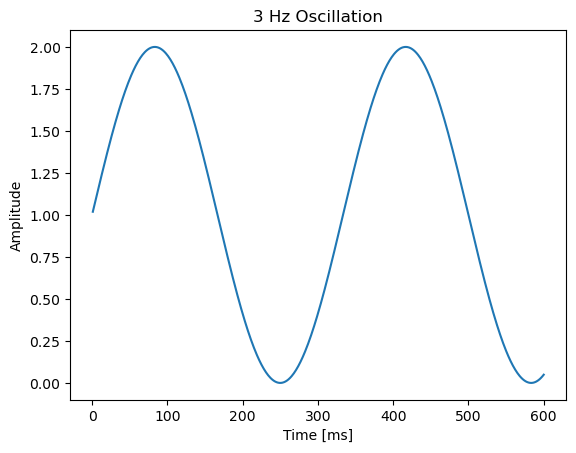

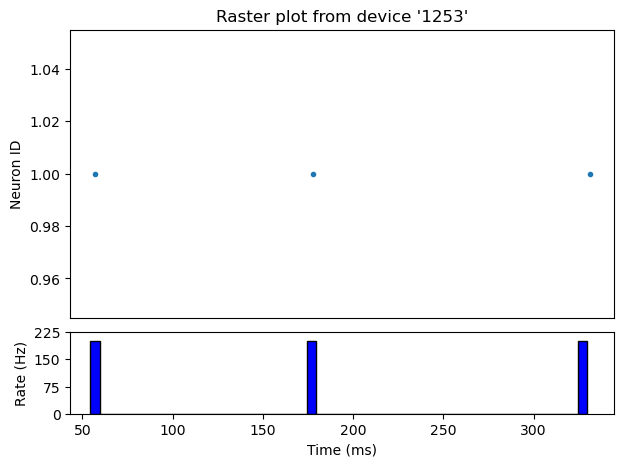

In [2]:
frequencies = [3,5, 10, 20, 30, 40, 50, 60, 70]  # Frequencies in Hz

duration = 600 #ms
dt = 1.
t = np.arange(0,duration,dt)+dt
amp_thres = 8000 

frequency_capacity = []

for i in range(len(frequencies)):
    nest.ResetKernel()
    nest.resolution = dt
    frequency = frequencies[i]
    signal = (np.sin(2 * np.pi * frequency * t/1000)+1)
    pl.figure()
    pl.plot(t, signal)
    pl.xlim()
    pl.xlabel(r'Time [ms]')
    pl.ylabel(r'Amplitude')
    pl.title(f'{frequency} Hz Oscillation')

    
    stim_pgen = nest.Create('inhomogeneous_poisson_generator', 1)

    signal = amp_thres + signal * 5000
    stim_pgen.set({'rate_times': t, 'rate_values': signal})
    #idxs = np.where(signal == np.max(signal))[0]
    #stim_pgen.set({'rate_times': idxs.astype(float), 'rate_values': signal[idxs].astype(float)})
    
    gamma = 0.25               # relative number of inhibitory connections
    NE = 1000                  # number of excitatory neurons (10.000 in [1])
    NI = int(gamma * NE)       # number of inhibitory neurons
    CE = 200                  # indegree from excitatory neurons
    CI = int(gamma * CE)       # indegree from inhibitory neurons

# synapse parameters
    w = 0.1                    # excitatory synaptic weight (mV)
    g = 5.                     # relative inhibitory to excitatory synaptic weight
    d = 1.5                    # synaptic transmission delay (ms)

# neuron paramters
    neuron_params = {
        'C_m': 1.0,            # membrane capacity (pF)
        'E_L': 0.,             # resting membrane potential (mV)
        'I_e': 0.,             # external input current (pA)
        'V_m': 0.,             # membrane potential (mV)
        'V_reset': 10.,        # reset membrane potential after a spike (mV)
        'V_th': 20.,           # spike threshold (mV)
        't_ref': 2.0,          # refractory period (ms)
        'tau_m': 20.,          # membrane time constant (ms)
    }
    # set default parameters for neurons and create neurons
    nest.SetDefaults('iaf_psc_delta', neuron_params)
    neurons_e = nest.Create('iaf_psc_delta', NE)
    neurons_i = nest.Create('iaf_psc_delta', NI)

    # create spike detectors
    spikes_e = nest.Create('spike_recorder')
    spikes_inp = nest.Create('spike_recorder')
    # E synapses
    syn_exc = {'delay': d, 'weight': w}
    conn_exc = {'rule': 'fixed_indegree', 'indegree': CE}
    nest.Connect(neurons_e, neurons_e, conn_exc, syn_exc)
    nest.Connect(neurons_e, neurons_i, conn_exc, syn_exc)

    # I synapses
    syn_inh = {'delay': d, 'weight': - g * w}
    conn_inh = {'rule': 'fixed_indegree', 'indegree': CI}
    nest.Connect(neurons_i, neurons_e, conn_inh, syn_inh)
    nest.Connect(neurons_i, neurons_i, conn_inh, syn_inh)

    # spike detector
    nest.Connect(neurons_e, spikes_e)
    nest.Connect(stim_pgen, spikes_inp)

    # connect poisson generator using the excitatory connection weight
    nest.Connect(stim_pgen, neurons_e, syn_spec=syn_exc)
    nest.Connect(stim_pgen, neurons_i, syn_spec=syn_exc)
    
    vm = nest.Create('multimeter', 1, {'record_from': ['V_m'], 'interval': 1})
    nest.Connect(vm, neurons_e)
    nest.Simulate(duration)
    
    
    nest.raster_plot.from_device(spikes_inp, hist=True)
    nest.raster_plot.from_device(spikes_e, hist=True)

    activity = vm.events
    indices = np.sort(np.unique(vm.events['senders']))
    states = np.zeros((NE, duration-1))
    for idx, i in enumerate(indices):
        states[idx,:] = activity['V_m'][np.where(activity['senders']==i)[0]]
   
    fig = pl.figure()
    ax1 = fig.add_subplot(121)
    ax1.imshow(states, aspect='auto', cmap='BuPu')
    ax2 = fig.add_subplot(122, projection='3d')
    #pca_fit = PCA(n_components=np.shape(states)[0])
    pca_fit = PCA(n_components=3)

    X = pca_fit.fit_transform(states.T)
    ax2.plot(X[:, 0], X[:, 1], X[:, 2], color='k', lw=1)

    def compute_capacity(x, z):
        """
        Compute capacity to reconstruct z based on linearly combining x

        Parameters
        ----------
        x : np.ndarray
            state matrix(NxT)
        z : np.ndarray
            target output (1xT)

        Returns
        -------
        z_hat : np.ndarray
            Reconstructed (predicted) signal

        """
        reg = LinearRegression(n_jobs=-1, fit_intercept=False).fit(x.T, z)
        W_out = reg.coef_
        z_hat = np.dot(W_out, x)

        covs = np.cov(z_hat, z)[0, 1] ** 2.0
        vars = np.var(z) * np.var(z_hat)
        capacity = covs / vars

        error = np.mean((z - z_hat) ** 2)
        return z_hat, capacity, error

    # computes memory capacity at stimulus offset
    estimate, capacity_f, error = compute_capacity(states, signal[1:])
    print("Capacity={0}, MSE={1}".format(str(capacity_f), str(error)))
    
    frequency_capacity.append(capacity_f)

    max_lag = 330.   # [ms] in this example
    step_lag = 100.   # [ms] evaluate in discrete time points (alternatively set == 1. for higher resolution)
    time_lags = np.arange(0, max_lag, step_lag)+dt

    indices = [np.where(idx==t)[0][0] for idx in time_lags]

    memory_capacity = []

    for idx, lag in zip(indices, time_lags):
    
         # shift the target signal
        if idx > 0:
            shifted_signal = signal[:-idx]
        else:
            shifted_signal = signal
    
     # shift the population states
        st = states[:, idx:]
    
     # compute capacity
        estimate, capacity, error = compute_capacity(st, shifted_signal[:-1])
    
        print("Lag = {0} ms".format(str(lag)))
        print("Capacity={0}, MSE={1}".format(str(capacity), str(error)))
    
        memory_capacity.append(capacity)
    
    fig, ax = pl.subplots() 
    
    ax.plot(time_lags, memory_capacity)
    ax.set_xlim([0., max_lag])
    
    ax.set_xlabel(r'Time lag $\tau$ [ms]')
    ax.set_ylabel(r'Capacity')
    print("Total capacity: {0} ms".format(str(np.sum(memory_capacity)*step_lag)))

pl.figure()
pl.plot(np.array(frequencies), frequency_capacity)
pl.title("Capacity = f(freq)")
pl.xlabel('Frequency [Hz]')
pl.ylabel('Capacity')